# Sentiment Based Product Recommendation System

In [1]:
# Import python libraries
import numpy as np
import pandas as pd
import re, string
from collections import Counter

# Import Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import NLTK libraries
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from wordcloud import WordCloud

# Import data imbalance libraries
from imblearn.over_sampling import SMOTE

# Import sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Import Cosine and Adjusted Cosine similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Naive Bayes from sklearn
from sklearn.naive_bayes import MultinomialNB
# Importing Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# importing libraries for XGBoost classifier
from xgboost import XGBClassifier
# Import pickle to save and load the model
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import User Defined variables
import constants as const

### Data sourcing

In [2]:
# Load the data from the input file
df_original = pd.read_csv(const.DATA_DIRECTORY + 'sample30.csv')

In [3]:
print(df_original.shape)
df_original.head(5)

(30000, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


### Exploratory Data Analysis

In [4]:
# Start with Handling Null values

def MissingData(df):
    # summing up the missing values (column-wise) and displaying fraction of NaNs
    null_count = df[df.columns[df.isna().any()]].isna().sum().sort_values(ascending=False)
    null_percentage = (df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]).sort_values(ascending=False)
    null_data = pd.concat([null_count, null_percentage], axis=1, keys=['Count', 'Percentage'])
    return null_data

MissingData(df_original)

# reviews_userProvince and reviews_userCity have over 93% NULL values and are not useful for analysis. We will remove them from the dataset.
# reviews_didPurchase column has over 46% NULL values. This field is not useful in building either Sentiment/Recommender system as well and will be removed.
# copy the original data frame to another df

df_clean = df_original.copy()
df_clean.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'], inplace=True)

# check for missing data again
MissingData(df_clean)

# check column reviews_DoRecommend
df_clean.reviews_doRecommend.value_counts(normalize=True)
# can delete this column as it makes no sense to keep a column with 94% true data
df_clean.drop(columns=['reviews_doRecommend'], inplace=True)

# check for missing data again
MissingData(df_clean)

# Reviews Title is a critical feature for the sentiment classification model and since the null data is less 0.63% it makes sense to remove these records from the data frame
# Checking rowcount before deletion
df_clean.shape
df_clean = df_clean[~ df_clean.reviews_title.isna()]
df_clean.shape

# check for missing data again
MissingData(df_clean)

# Reviews UserName is a critical feature for the recommendation model and since the null data is less 0.20% it makes sense to remove these records from the data frame
# Checking rowcount before deletion
df_clean.shape
df_clean = df_clean[~ df_clean.reviews_username.isna()]
df_clean.shape

# check for missing data again
MissingData(df_clean)

# check column reviews_date
df_clean.reviews_date.value_counts(normalize=True)
# can delete this column as we will not need the review date for either classification or recommendation engine
df_clean.drop(columns=['reviews_date'], inplace=True)

# check for missing data again
MissingData(df_clean)

# As there is only one record with missing data for user_sentiment, we will read the record manually and update the value.
df_clean[df_clean.user_sentiment.isna()]
# overall from the values the sentiment seems Positive and we will update accordingly
df_clean.user_sentiment.fillna('Positive', inplace=True)

# check for missing data again
MissingData(df_clean)

# can delete the column manufacturer as we will not need the manufacturer value for classification or recommendation engine
df_clean.drop(columns=['manufacturer'], inplace=True)

# check for missing data again
MissingData(df_clean)

df_clean.shape
# Null values are fully taken care now with null values various treatments with final shape of 29748 rows and 9 columns

(29748, 9)

<AxesSubplot: xlabel='user_sentiment', ylabel='count'>

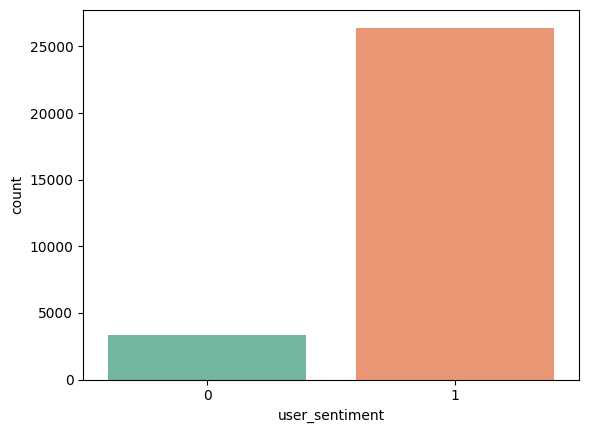

In [5]:
# Analyze the user_sentiment column

# map the categorical user_sentiment to numerical 1 or 0 for Classification Model
df_clean['user_sentiment'] = df_clean['user_sentiment'].map({'Positive':1,'Negative':0})
# get the value count of user_sentiments column
df_clean["user_sentiment"].value_counts(normalize=True)
# Visualize using count plot
sns.countplot(x='user_sentiment', data= df_clean, palette="Set2")
# We can see in user sentiment that positive reviews are way higher than negative causing imbalance. we may have to do Class Imbalance techniques during modelling.

<AxesSubplot: xlabel='reviews_rating', ylabel='count'>

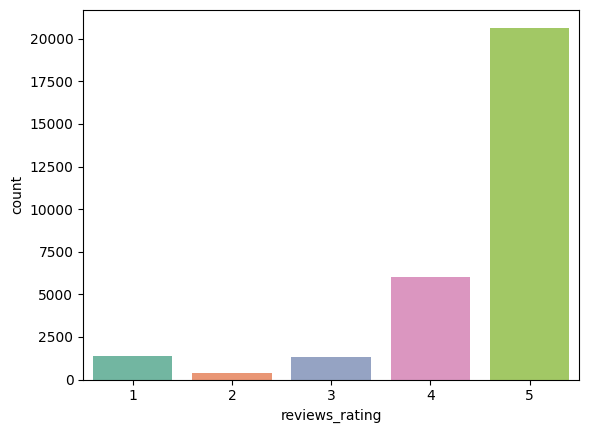

In [6]:
# Analyze the reviews_rating column

df_clean["reviews_rating"].value_counts(normalize=True)
df_clean["reviews_rating"].describe()
# Looks like the 75% of reviews have rating of 4 and above
# 50% of the records have rating of 5
# visualize the reviews_rating..
sns.countplot(x='reviews_rating', data= df_clean, palette="Set2")

In [7]:
# Analyze the Reviews_Rating and user_sentiment for corelation analysis

# check the ratings for positive sentiment records
df_clean[df_clean["user_sentiment"]==1]["reviews_rating"].describe()

# check the ratings for negative sentiment records
df_clean[df_clean["user_sentiment"]==0]["reviews_rating"].describe()
# seems to be an issue with data as the 50% of records have rating 5 for negative sentiment reviews and calls for detailed analysis
# analyse the actual title and reviews for such ambigous records
df_clean[(df_clean["user_sentiment"]==1) & (df_clean["reviews_rating"]<4)][["reviews_title","reviews_text"]]
df_clean[(df_clean["user_sentiment"]==0) & (df_clean["reviews_rating"]>=4)][["reviews_title","reviews_text"]]
pd.crosstab(df_clean["user_sentiment"], df_clean["reviews_rating"], margins=True)
# As per the above results, there looks to be mismtach between review_rating and user_sentiment
# There are records that have higher user rating but user sentiment is negative and lower user rating but user sentiment is positive.
# We can either clean up those records or update the target column to the correct user sentiment, so that will be helpful for modelling.
# Here, updating the user_sentiment to 0 (but was 1) when the reviews_rating is less than 4, and updating the user_sentiment to 1(but was 0), when the reviews_rating is greater than or equal to 4
df_clean.loc[(df_clean["user_sentiment"]==1) & (df_clean["reviews_rating"]<4), "user_sentiment"] = 0
df_clean.loc[(df_clean["user_sentiment"]==0) & (df_clean["reviews_rating"]>=4), "user_sentiment"] = 1
pd.crosstab(df_clean["user_sentiment"], df_clean["reviews_rating"], margins=True)
# from the above cross table, we can see that we don't have mismatch anymore between the reviews_rating and user_sentiment
df_clean["user_sentiment"].value_counts()
# Still imbalance in the data with higher positive reviews 26646 as positive and 3102 as negative

1    26646
0     3102
Name: user_sentiment, dtype: int64

<AxesSubplot: xlabel='brand'>

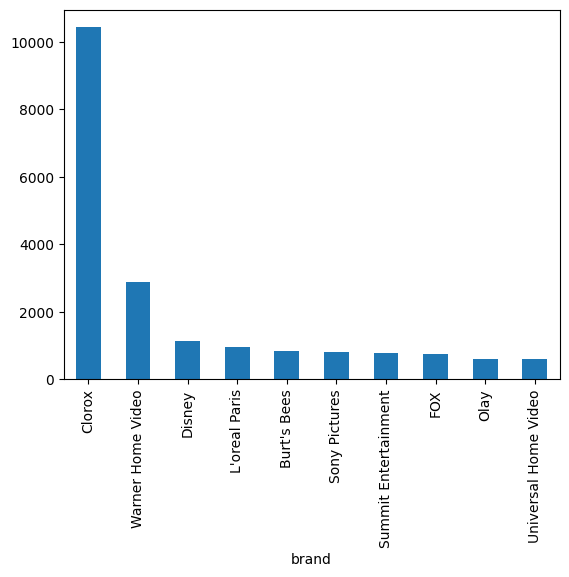

In [8]:
# Analyze the brand column

df_clean["brand"].value_counts()
# Clorox, Warner home video, Disney, Loreal and Fox are the top 5 brands
# filter top 10 brands with positive sentiment
# Filter the top 10 brands among the positive sentiments
df_clean[df_clean['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False).head(10).plot(kind='bar')

<AxesSubplot: xlabel='brand'>

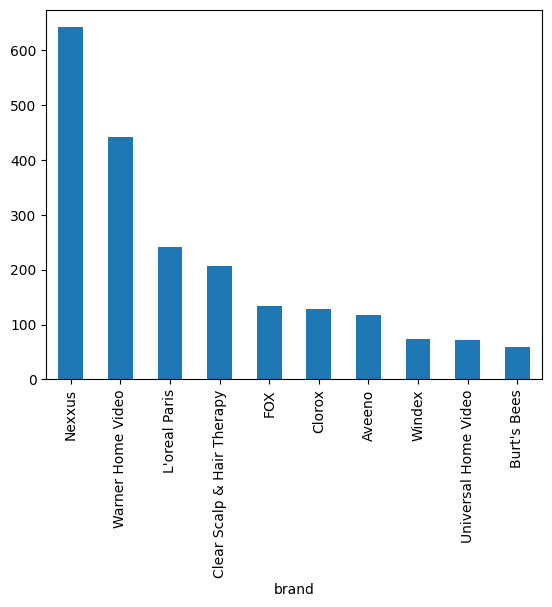

In [9]:
# Filter the top 10 brands among the negative sentiments
df_clean[df_clean['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False).head(10).plot(kind='bar')

In [10]:
# Analyze the reviews_username column
df_clean["reviews_username"].value_counts()
# Overall distribution looks OK and there is a long tail of user vs product rating
#plot the top 10 customers by 'positive user sentiment'
df_clean[df_clean['user_sentiment']==1].groupby('reviews_username')['reviews_username'].count().sort_values(ascending=False)[:10]

reviews_username
mike                 36
byamazon customer    31
chris                28
jojo                 13
sandy                13
rick                 13
john                 13
tony                 13
movielover           12
james                12
Name: reviews_username, dtype: int64

In [11]:
#plot the top 10 customers by 'negative user sentiment'
df_clean[df_clean['user_sentiment']==0].groupby('reviews_username')['reviews_username'].count().sort_values(ascending=False)[:10]

reviews_username
byamazon customer    10
mike                  5
disappointed          5
kevman79              4
mark                  4
jill                  4
island girl           4
cool                  4
chris                 3
rachael               3
Name: reviews_username, dtype: int64

In [12]:
# Type Conversion-Before we start the pre-processing steps, we need to make sure that all the text columns are converted to string type for future text operations.
df_clean['brand'] = df_clean['brand'].astype(str)
df_clean['categories'] = df_clean['categories'].astype(str)
df_clean['name'] = df_clean['name'].astype(str)
df_clean['reviews_text'] = df_clean['reviews_text'].astype(str)
df_clean['reviews_title'] = df_clean['reviews_title'].astype(str)
df_clean['reviews_username'] = df_clean['reviews_username'].astype(str)

# Since we want on feature for the reviews let us combine the title and reviews
df_clean["reviews_title"] = df_clean["reviews_title"].fillna('')
df_clean["reviews_full_text"] = df_clean[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')
df_clean.reviews_full_text.head(10)

# check for missing data again
MissingData(df_clean)
# No Missing data present now

# Keep the df_clean intact for later use for recommendation and filtering
# For now lets create a Df for sentiment classification model
# The above data source is final and can be used for modeling - classification and recommendation

# Create data frame for classification model
df_classification = df_clean[['id','name','reviews_full_text', 'user_sentiment']]

df_classification.head(4)

,id,name,reviews_full_text,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very goo...,1
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected a...,1
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Disappointed. I read through the reviews on he...,0


In [13]:
df_classification.shape
# 29748 rows and 4 columns

(29748, 4)

### Text PreProcessing

In [14]:
# NLP Text Preprocessing for the classification modelling
# create functions for different NLP tasks for the review data

# Function to clean the text and remove all the unnecessary elements.
def remove_punctuations(sentence):
    sentence = sentence.lower() # Text to lowercase
    sentence = sentence.strip() # strip the extra spaces
    pattern = '[^\w\s]' # Removing punctuation
    sentence = re.sub(pattern, '', sentence)
    return sentence

# Function to remove the stop words.
stop_words = set(stopwords.words('english'))
def remove_stopword(sentence):
    words = [word for word in sentence.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

# Function to do lemmatization of the tokens
lemmatizer = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# lemmatization function
def lemma_text(sentence):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(sentence))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(words)

# Apply the various functions created above to create the model data frame
df_classification["reviews_full_text_cleaned"] = df_classification.reviews_full_text.apply(lambda x: remove_punctuations(x))
df_classification["reviews_full_text_cleaned"].head(5)

df_classification["reviews_full_text_lemma"] = df_classification.reviews_full_text_cleaned.apply(lambda x: lemma_text(x))
df_classification["reviews_full_text_lemma"].head(5)

0    awesome love album good hip hop side current p...
1       good good flavor review collect part promotion
2                                     good good flavor
3    disappoint read review look buy one couple lub...
4    irritation husband buy gel u gel caused irrita...
Name: reviews_full_text_lemma, dtype: object

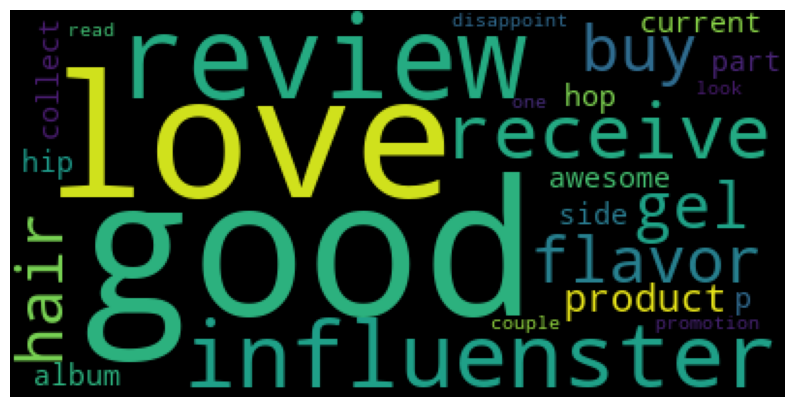

In [15]:
# Build a word cloud to find the top 25 words by frequency among all the reviews after processing the text
wordcloud = WordCloud(stopwords=stop_words,max_words=25).generate(str(df_classification.reviews_full_text_lemma))
plt.figure(figsize= (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Function to get the most common words from the feature
def getMostCommonWords(reviews, n_most_common):
    # flatten lemma review column into a list of words, and set to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]
    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]
    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]
    return Counter(flattened_reviews).most_common(n_most_common)

# Get 15 common words for positive reviews
pos_reviews = df_classification[df_classification['user_sentiment']==1]
getMostCommonWords(pos_reviews['reviews_full_text_lemma'],15)

# Get 15 common words for negative reviews
neg_reviews = df_classification[df_classification['user_sentiment']==0]
getMostCommonWords(neg_reviews['reviews_full_text_lemma'],15)

# create a function to get the ngrams frequency of the reviews
def get_top_n_ngram(corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
#Print the top 10 bigrams for positive reviews
common_words = get_top_n_ngram(pos_reviews['reviews_full_text_lemma'], 2, 10)
pd.DataFrame(common_words)

,0,1
0,review collect,7920
1,collect promotion,7920
2,clorox wipe,2803
3,great product,1942
4,great movie,1739
5,easy use,1552
6,love clorox,1223
7,love product,1135
8,use clorox,1088
9,good movie,922


In [17]:
#Print the top 10 bigrams for negative reviews
common_words = get_top_n_ngram(neg_reviews['reviews_full_text_lemma'], 2, 10)
pd.DataFrame(common_words)

,0,1
0,new formula,520
1,old formula,515
2,bring old,369
3,review collect,345
4,collect promotion,345
5,exxtra gel,205
6,use product,180
7,make hair,156
8,shampoo conditioner,147
9,gel year,127


In [18]:
#Print the top 10 trigrams for positive reviews
common_words = get_top_n_ngram(pos_reviews['reviews_full_text_lemma'], 3, 10)
pd.DataFrame(common_words)

,0,1
0,review collect promotion,7920
1,love clorox wipe,601
2,use clorox wipe,550
3,clorox disinfect wipe,548
4,review collected promotion,452
5,clean review collect,426
6,use review collect,351
7,product review collect,342
8,great product love,288
9,great movie great,268


In [19]:
#Print the top 10 trigrams for negative reviews
common_words = get_top_n_ngram(neg_reviews['reviews_full_text_lemma'], 3, 10)
pd.DataFrame(common_words)

,0,1
0,review collect promotion,345
1,bring old formula,237
2,use product year,81
3,opinion review collect,63
4,nexxus exxtra gel,62
5,receive product free,59
6,exxtra gel year,44
7,use gel year,43
8,use old formula,42
9,testing purpose opinion,38


### Feature Extraction

In [20]:
# Feature Extraction using TF-IDF, handling imbalance and train test split

# Initialize the TfidfVectorizer max features 650
# max_df = 0.95 means ignore terms that appear in more than 95% of the reviews
# min_df = 5 means ignore terms that appear in less than 5 reviews
# ngram range of 2
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True, ngram_range=(1,2))

# Create X and y variables
X = tfidf_vectorizer.fit_transform(df_classification['reviews_full_text_lemma'])
y= df_classification['user_sentiment']

In [21]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22311, 650) (22311,)
Test shapes: (7437, 650) (7437,)


In [22]:
# Handle class imbalance
df_classification.user_sentiment.value_counts(normalize=True)
# 89.5% positive reviews and 10.5% negative reviews which means big imbalance
# Apply SMOTE technique to balance the data
# SMOTE - oversampling method that generates synthetic samples for the minority class
print("Before doing SMOTE", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)
print("After doing SMOTE", Counter(y_train_sm))
# Perfect balance now post SMOTE for positive and negative sentiment reviews

Before doing SMOTE Counter({1: 19967, 0: 2344})
After doing SMOTE Counter({1: 19967, 0: 19967})


### Model Building: Sentiment Classification

In [23]:
# Define functions for model training, model evaluation, confusion matrix
class ModelBuilder:
    # initialization constructor
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    # function to train the model and return predictions
    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)

    # function to evaluate the model and see confusion matrix and ROC curve
    def evaluate_model(self, y_pred_class):
        
        print("*"*50)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*50)
        self.classification_report(y_pred_class)
        print("*"*50)
        self.confusion_matrix(y_pred_class)
        print("*"*50)
        #print("\n")

        #metrics.plot_roc_curve(self.model, self.x_test, self.y_test)
        metrics.RocCurveDisplay.from_estimator(self.model, X_test, y_test)
        return self.result_metrics

    # function to generate model evaluation metrics like accuracy and f1 score etc
    def evaluate_metrics(self, y_pred_class):
        result_metrics = []
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")

        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics

    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])

    # function to plot the confusion matrix
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    # function to generate the ootb classification report from the metrics class
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

#### Logistic Regression Model

CPU times: total: 0 ns
Wall time: 0 ns


**************************************************
Accuracy is : 87.4%
Precision is : 96.9%
Recall is : 88.8%
F1 Score is : 92.7%
Roc-Auc Score is:90.2%
**************************************************


              precision    recall  f1-score   support

           0       0.43      0.75      0.55       758
           1       0.97      0.89      0.93      6679

    accuracy                           0.87      7437
   macro avg       0.70      0.82      0.74      7437
weighted avg       0.91      0.87      0.89      7437

**************************************************




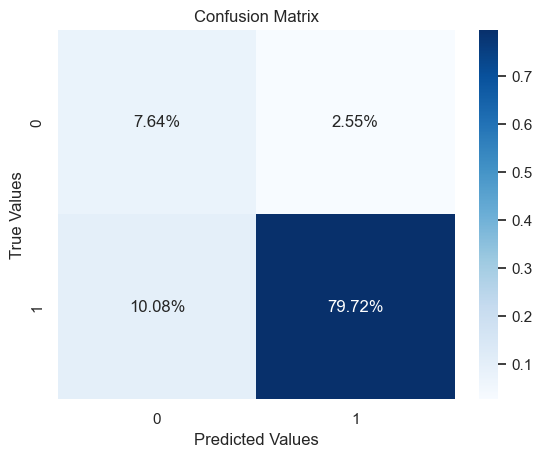

**************************************************




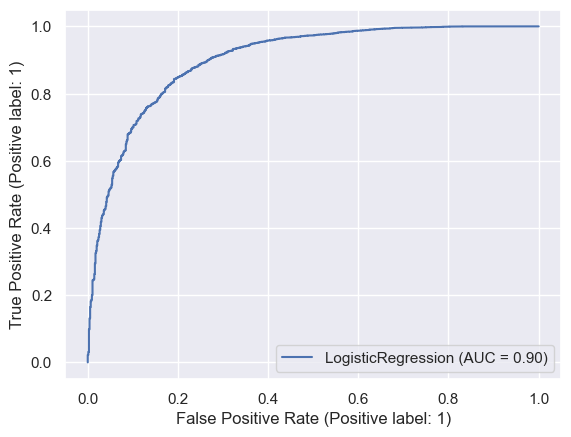

In [24]:
# Build different Models to evaluate model statistics

# Logistic Regression Model
%time
logreg_model = LogisticRegression(random_state=42, max_iter=100,solver='liblinear')
logistic_modelbuilder = ModelBuilder(logreg_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class  = logistic_modelbuilder.train_model()
lr_metrics = logistic_modelbuilder.evaluate_model(y_pred_class)
# F1 Accuracy for the base logistic regression model is good with 92.7%

#### Naive Bayes Model

CPU times: total: 0 ns
Wall time: 0 ns


**************************************************
Accuracy is : 80.3%
Precision is : 97.6%
Recall is : 80.0%
F1 Score is : 87.9%
Roc-Auc Score is:89.4%
**************************************************


              precision    recall  f1-score   support

           0       0.32      0.83      0.46       758
           1       0.98      0.80      0.88      6679

    accuracy                           0.80      7437
   macro avg       0.65      0.81      0.67      7437
weighted avg       0.91      0.80      0.84      7437

**************************************************




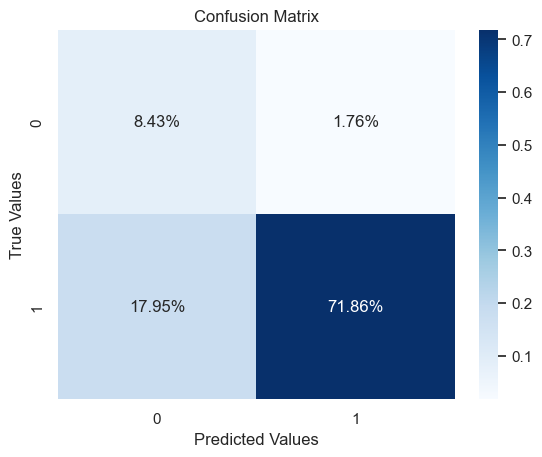

**************************************************




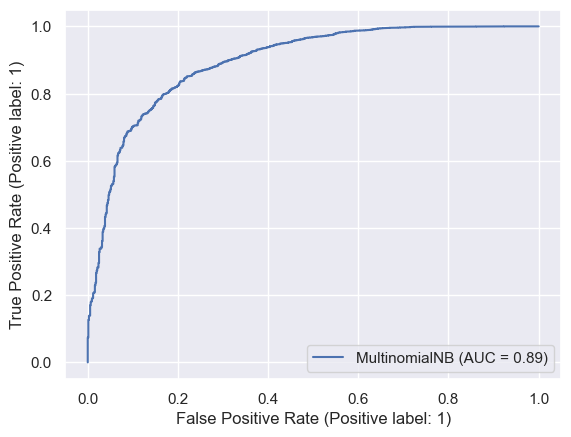

In [25]:
# Naive bayes Model
%time
mnb_model = MultinomialNB(alpha=1.0)
mnb_modelbuilder = ModelBuilder(mnb_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class  = mnb_modelbuilder.train_model()
mnb_metrics = mnb_modelbuilder.evaluate_model(y_pred_class)
# F1 Accuracy for the base Naive Bayes model is good with 87.9% F1 score. So LR model better than NB model so far for the base model

#### Decision Tree Model



**************************************************
Accuracy is : 82.2%
Precision is : 95.9%
Recall is : 83.8%
F1 Score is : 89.4%
Roc-Auc Score is:82.5%
**************************************************


              precision    recall  f1-score   support

           0       0.32      0.68      0.44       758
           1       0.96      0.84      0.89      6679

    accuracy                           0.82      7437
   macro avg       0.64      0.76      0.67      7437
weighted avg       0.89      0.82      0.85      7437

**************************************************




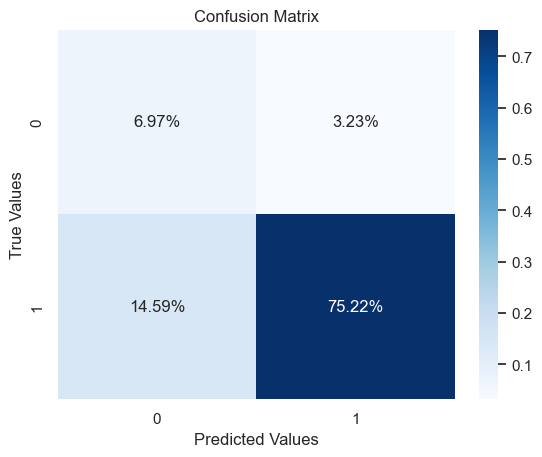

**************************************************




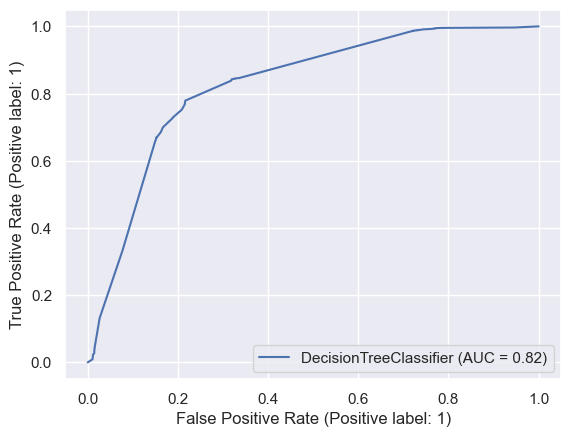

In [26]:
# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)
dt_modelbuilder = ModelBuilder(dt_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)
# F1 Accuracy for the decision tree model is good with 89.4%.

#### Random Forest Model

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 4 folds for each of 64 candidates, totalling 256 fits


**************************************************
Accuracy is : 79.3%
Precision is : 96.8%
Recall is : 79.6%
F1 Score is : 87.4%
Roc-Auc Score is:86.2%
**************************************************


              precision    recall  f1-score   support

           0       0.30      0.77      0.43       758
           1       0.97      0.80      0.87      6679

    accuracy                           0.79      7437
   macro avg       0.63      0.78      0.65      7437
weighted avg       0.90      0.79      0.83      7437

**************************************************




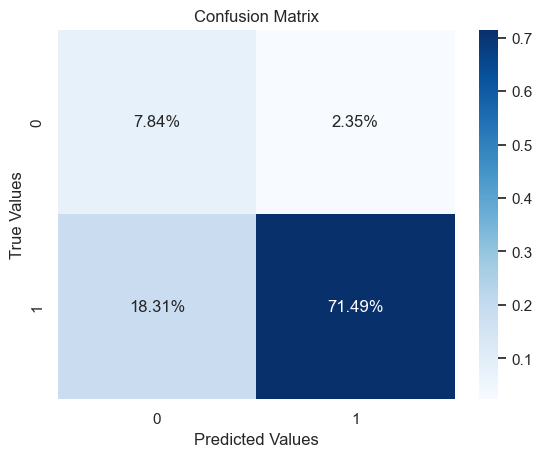

**************************************************




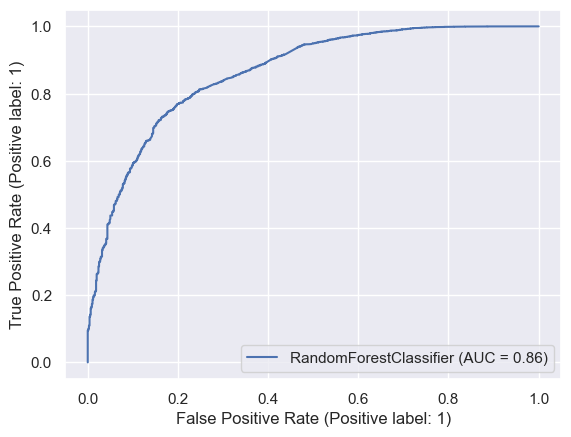

In [27]:
# Random Forest Model
rf_model = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=params, cv=4, n_jobs=-1, verbose=1, scoring="f1")
%time
grid_search.fit(X_train_sm, y_train_sm)
rf_best_model = grid_search.best_estimator_
rf_modelbuilder = ModelBuilder(rf_best_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class  = rf_modelbuilder.train_model()
rf_metrics = rf_modelbuilder.evaluate_model(y_pred_class)
# F1 Accuracy for the Random Forest model is 87.36%

#### XGBoost Model



**************************************************
Accuracy is : 90.6%
Precision is : 96.0%
Recall is : 93.4%
F1 Score is : 94.7%
Roc-Auc Score is:90.7%
**************************************************


              precision    recall  f1-score   support

           0       0.53      0.66      0.59       758
           1       0.96      0.93      0.95      6679

    accuracy                           0.91      7437
   macro avg       0.75      0.80      0.77      7437
weighted avg       0.92      0.91      0.91      7437

**************************************************




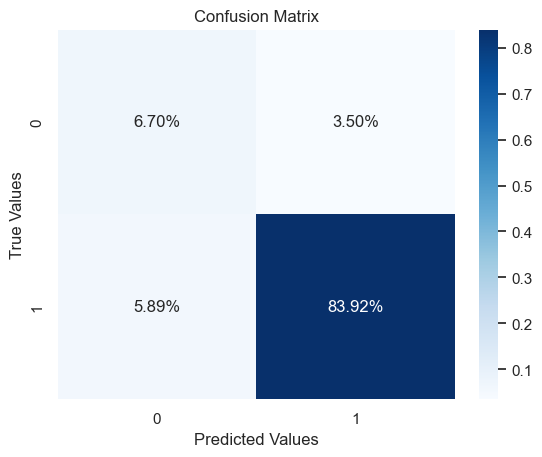

**************************************************




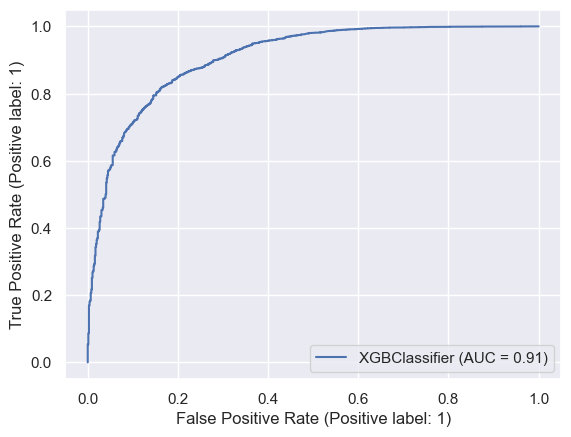

In [28]:
xgbclf_model = XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42)
xgb_modelbuilder = ModelBuilder(xgbclf_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class  = xgb_modelbuilder.train_model()
xg_metrics = xgb_modelbuilder.evaluate_model(y_pred_class)
# F1 accuracy for the XGBoost classifier model is 94.58%

#### Model Evaluation and selection

In [29]:
# Creating a data frame to store all the accuracy metrics of all the 4 models built for side by side comparison and choosing the best model out of 4

modelmetrics_datatable = {
                        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1Score', 'Auc Score'],
                        'Logistic Regression': lr_metrics,
                        'Naive Bayes': mnb_metrics,
                        'Decision Tree': dt_metrics_cv,
                        'Random Forest': rf_metrics,
                        'XG Boost': xg_metrics
                    }

df_model_metrics = pd.DataFrame(modelmetrics_datatable,
                                columns = ['Metric', 'Logistic Regression', 'Naive Bayes',
                                            'Decision Tree', 'Random Forest', 'XG Boost'] )
df_model_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forest,XG Boost
0,Accuracy,0.873605,0.802878,0.821837,0.793331,0.906145
1,Precision,0.968949,0.976073,0.958862,0.968135,0.960006
2,Recall,0.887708,0.800120,0.837551,0.796077,0.934421
3,F1Score,0.926551,0.879381,0.894110,0.873716,0.947041
4,Auc Score,0.902026,0.894002,0.824787,0.862437,0.907298


On the comparison of the 5 models, XGboost classifier model has the highest metrics for f1 score (balance of precision and recall) and AUC score.

In [61]:
# Create a user defined function to save the model
def save_model(model, filename):
    pickle.dump(model, open(const.ML_MODELS_DIRECTORY + filename, 'wb'))

save_model(xgbclf_model, const.SENTIMENT_CLASSIFICATION_MODEL)
save_model(tfidf_vectorizer, const.WORD_VECTORIZER)
save_model(df_classification, const.PROCESSED_DATA)

### Model Building: Recommendation Model

We will build User-User and item-item collaboarative filtering recommendation Engine and use it for recommending products. Later we will combine the selected recommendation filter and user the sentiment to filter the products with positive reviews
- User-User: Find similar users first and then recommend products to users which would have been rated high by the similar group of users
- Item-Item: Find similar items based on ratings and use that to recommend the top rated products to users

In [31]:
# Build the dataset needed for Recommendation Engine
# Earlier we had kept the dataset df_clean intact for classification and recommendation
# Verify df_clean has no missing data

MissingData(df_clean)
df_recommendation = df_clean[['id','name','reviews_rating', 'reviews_username']]
print(df_recommendation.shape)
df_recommendation.head(5)

(29748, 4)


,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


In [32]:
# Split the recommendation dataset into train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)

# name columns for the recommendation dataset
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

# Create Pivot dataset in matrix format with columns as product IDs and rows as user names so we get a view of whch user has rated which product and what value
df_user_recommendation_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_user_recommendation_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10ten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11111111aaaaaaaaaaaaaaaaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Dummy train dataset

In [33]:
# We will create dummy train and dummy test dataset to mark the products already rated by the user so that they dont come up during prediction or evaluation
# Copy the train dataset into dummy_train
dummy_train = train.copy()
# The products not rated by a user is marked as 1 for prediction. this matrix form now has 1 and 0 with 1 as products not rated by the user
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1085,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10ten,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11111111aaaaaaaaaaaaaaaaa,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [34]:
# Adjusted cosine similarity measure will be used now to capture similarities between different users
# Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.
df_user_recommendation_pivot.index.nunique()
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_user_recommendation_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1.        0.        0.        ... 0.        0.        0.9486833]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        1.        0.       ]
 [0.        0.        0.        ... 1.        1.        0.       ]
 [0.9486833 0.        0.        ... 0.        0.        1.       ]]
(19268, 19268)


##### User-Based Recommendation Model

In [35]:
# User - User similarity predicition with the use of above correlation matrix. no correlation value of 0
# Making negative correlations to 0
user_correlation[user_correlation<0]=0

# taking a dot product of User correlation matrix and the pivot matrix
user_predicted_ratings = np.dot(user_correlation, df_user_recommendation_pivot.fillna(0))
user_predicted_ratings

# Multiply the predicted ratings with dummy matrix as we dont want the products which are already rated
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

# find 20 recommendations for a sample user 00sab00
user_input = "00sab00"
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]

# Show the top 20 recommended products - product id, name and similarity_score
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,109.709041
2480,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,65.684450
3322,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),33.300251
3962,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,32.242757
10322,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),29.225158
10843,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,25.706993
11038,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,23.756798
12597,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,16.872612
12749,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultravio...,15.343614
12937,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",12.132476


In [36]:
# Since prediction is now done, we will move to evaluation for User-User Collborative
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape
# Convert into the user-product matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()
user_correlation_df[user_column] = df_user_recommendation_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

# get the list of users from the common dataset from train and test
list_name = common.reviews_username.tolist()

# create a user correlation matrix with the list of common users in train and test by aligning the pivot matrix index
user_correlation_df.columns = df_user_recommendation_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape
# create user correlation matrix 2 with a transpose of matrix 1 with the list of common users
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
# create user correlation matrix 2 with a transpose of matrix 2
user_correlation_df_3 = user_correlation_df_2.T
# Mark the correlattion value with 0 for the negative coorelations
user_correlation_df_3[user_correlation_df_3<0]=0
# get the recommendations by doing a dot product of correlations and ratings
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings
# create a dummy test dataset with the common users and create a pivot matrix of the same
dummy_recommendation_test = common.copy()
dummy_recommendation_test[value_column] = dummy_recommendation_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_recommendation_test = pd.pivot_table(dummy_recommendation_test,index=user_column, columns = product_column, values = value_column).fillna(0)
dummy_recommendation_test.shape
# print both the matrix which has users and the evaluation test recommendations
common_user_based_matrix.head()
dummy_recommendation_test.head()
# get the final evaluation for the products not rated by the users in the test set
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_recommendation_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YnUMYglJLPUi8IJpK,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfm8yiLJeJML43AYyu,AVpfnS4eLJeJML43AfZe,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Calculate RMSE from the user-user evaluation
X  = common_user_predicted_ratings.copy()
X = X[X>0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = scaler.transform(X)
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
# print the final RMSE
print(rmse)

##### Item-Based Recommendation Model

In [54]:
# Item - Item Based Recommendation
df_item_recommendation_pivot = pd.pivot_table(train,index=product_column, columns=user_column, values=value_column)
df_item_recommendation_pivot.head()

mean = np.nanmean(df_item_recommendation_pivot, axis=1)
df_subtracted = (df_item_recommendation_pivot.T-mean).T
df_subtracted.head()

# Create Item similarity matrix using cosine similarity
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0

item_correlation[item_correlation<0]=0
item_correlation

# Prediction item - item recommendation
item_predicted_ratings = np.dot((df_item_recommendation_pivot.fillna(0).T),item_correlation)
item_predicted_ratings
# filtering for the products not rated by the users
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

# find 20 recommendations for a sample user 00sab00
user_input = "00sab00"
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations
# Show the top 20 recommended products - product id, name and similarity_score
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.155810
5,AVpfRoqcLJeJML436FqG,"Vicks Vaporub, Regular, 3.53oz",0.116640
78,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's C...,0.076969
220,AVpe7sl91cnluZ0-aI1Y,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,0.072359
250,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),0.066262
257,AVpfNc9cLJeJML434tza,Feit 60-Watt A19 Gu24 Base Led Light Bulb - So...,0.057727
265,AVpfQtEm1cnluZ0-hUpe,Jolly Time Select Premium Yellow Pop Corn,0.042138
285,AVpf5ujMilAPnD_xkQVi,D-Con Mice Bait Station - 3ct,0.034802
288,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,0.032289
309,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),0.029276


In [55]:
# Now the prediction is done, do the evaluation for item - item recommendation
common =  test[test.id.isin(train.id)]
common.shape
common.head(5)

common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
# create a user coorelation matrix with the list of common users in train and test by aligning the pivot matrix index
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
# create coorelations 3 with transpose of 2
item_correlation_df_3 = item_correlation_df_2.T
df_subtracted
# Mark the coorelattion value with 0 for the negative coorelations
item_correlation_df_3[item_correlation_df_3<0]=0
# get the recommendations by doing a dot product of correlations and ratings
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings
# create a dummy test dataset with the common users and create a pivot matrix of the same
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
# get the final evaluation for the products not rated by the users in the test set
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [56]:
# Calculate RMSE from the item-item evaluation
X  = common_item_predicted_ratings.copy()
X = X[X>0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = scaler.transform(X)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
# print the final rmse value
print(rmse)

##### Recommendation Model selection

RMSE for User-User based recommendation method is lower than Item-Item, hence we will use user-user based collaborative model for the next set of recommendations.

In [62]:
# save the final user-user based collaborative recommendation model
save_model(user_final_rating, const.RECOMMENDATION_MODEL)

### Improving the recommendations using the sentiment analysis model

In [58]:
# Now combine the classification model positive sentiment and from the top 20 from the recommendation system pick the top 5 who have the positive sentiment of the reviews
def combine_recommendations_review_sentiment(user):
    if (user in user_final_rating.index):
        # get the top 20 product recommendation using the trained ML model for the specified user
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        # for the top 20 get the classification for the top recommended 20 products
        df_classify_recommend = df_classification[df_classification.id.isin(recommendations)]
        # create the tfidf vectorizer for the records
        X =  tfidf_vectorizer.transform(df_classify_recommend["reviews_full_text_lemma"].values.astype(str))
        # predict the review sentiment values
        df_classify_recommend["predicted_sentiment"]= xgbclf_model.predict(X)
        df_classify_recommend = df_classify_recommend[['name','predicted_sentiment']]
        # group the data for each product
        df_classify_recommend_grouped = df_classify_recommend.groupby('name', as_index=False).count()
        # get the positive review count, total count and the overall percentage of positive reviews
        df_classify_recommend_grouped["pos_review_count"] = df_classify_recommend_grouped.name.apply(lambda x: df_classify_recommend[(df_classify_recommend.name==x) & (df_classify_recommend.predicted_sentiment==1)]["predicted_sentiment"].count())
        df_classify_recommend_grouped["total_review_count"] = df_classify_recommend_grouped['predicted_sentiment']
        df_classify_recommend_grouped['pos_sentiment_percent'] = np.round(df_classify_recommend_grouped["pos_review_count"]/df_classify_recommend_grouped["total_review_count"]*100, 2)
        # return the grouped values with the product based on percentage of positive reviews count
        return df_classify_recommend_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        # if the user is not present in the recommendation data flag user not found
        print(f"User {user} not found")

#### Making Top 5 product recommendations

In [59]:
# Test the above function for one of the user and get the top 5 recommendations
combine_recommendations_review_sentiment("08dallas")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
0,"Cetaphil Gentle Skin Cleanser, 2oz",7,7,7,100.00
4,Clorox Disinfecting Wipes Value Pack Scented 1...,8524,8475,8524,99.43
3,Clorox Disinfecting Bathroom Cleaner,2039,2010,2039,98.58
11,Mrs. Meyer's174 Lemon Verbena Laundry Scent Bo...,29,28,29,96.55
13,Olay Regenerist Deep Hydration Regenerating Cream,634,601,634,94.79


In [60]:
combine_recommendations_review_sentiment("00sab00")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
4,Clorox Disinfecting Wipes Value Pack Scented 1...,8524,8475,8524,99.43
3,Clorox Disinfecting Bathroom Cleaner,2039,2010,2039,98.58
13,Planes: Fire Rescue (2 Discs) (includes Digita...,1140,1075,1140,94.30
16,The Resident Evil Collection 5 Discs (blu-Ray),845,793,845,93.85
9,Jason Aldean - They Don't Know,204,190,204,93.14
